In [8]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from peft import get_peft_model, LoraConfig, TaskType
from transformers import TrainingArguments, Trainer
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.amp import autocast
from datasets import load_dataset
import matplotlib as plt
import matplotlib.pyplot as plt
import os
import sys

In [4]:
# Load the dataset
ds = load_dataset("keivalya/MedQuad-MedicalQnADataset")

# Extract the training and validation subsets
training_data = ds['train'][:15000]
validation_data = ds['train'][15000:16000]

# Convert the dataset columns into dictionary format manually
training_question = training_data['Question']
training_answer = training_data['Answer']
validation_question = validation_data['Question']
validation_answer = validation_data['Answer']

In [5]:
class makeDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs['input_ids'])

    def __getitem__(self, idx):
        # Extract the input_ids and attention_mask for the question
        input_ids = self.inputs['input_ids'][idx]
        attention_mask = self.inputs['attention_mask'][idx]

        # Extract the labels (input_ids for the answer)
        labels = self.targets['input_ids'][idx]

        # Return the input and output as a dictionary
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }

In [ ]:
# Load pre-trained GPT-2 model and tokenizer
model_name = "gpt2"  # Default to GPT small
GPTmodel = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Configure LoRA
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8,  # Rank of the low-rank adaptation matrices
    lora_alpha=32,  # LoRA scaling factor
    lora_dropout=0.1,  # Dropout for LoRA layers
    target_modules = ["c_attn", "c_proj"]
)

# Prepare model for LoRA tuning
model = get_peft_model(GPTmodel, lora_config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

#tokenize dataset
tokenizer.pad_token = tokenizer.eos_token
maxLength = 64
tokenized_training_question = tokenizer(training_question, truncation=True, padding='max_length', return_tensors="pt", max_length = maxLength)
tokenized_training_answer = tokenizer(training_answer, truncation=True, padding=True, return_tensors="pt", max_length = maxLength)
tokenized_validation_question = tokenizer(validation_question, truncation=True, padding='max_length', return_tensors="pt", max_length = maxLength)
tokenized_validation_answer = tokenizer(validation_answer, truncation=True, padding=True, return_tensors="pt", max_length = maxLength)

print(f"Tokenized Training Questions Shape: {tokenized_training_question['input_ids'].shape}")
print(f"Tokenized Training Answers Shape: {tokenized_training_answer['input_ids'].shape}")

# Make sure it's divisible by batch size so last batch works fine
batch_size = 20
train_dataset = makeDataset(tokenized_training_question, tokenized_training_answer)
val_dataset = makeDataset(tokenized_validation_question, tokenized_validation_answer)
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Define training arguments
num_epochs = 3  # Number of training epochs
training_args = TrainingArguments(
    output_dir='./results',        # Directory to save model checkpoints
    num_train_epochs=num_epochs,            # Number of training epochs
    per_device_train_batch_size=batch_size, # Batch size per device
    per_device_eval_batch_size=batch_size,  # Batch size for evaluation
    warmup_steps=2,              # Number of warmup steps
    weight_decay=0.01,             # Weight decay
    logging_dir='./logs',          # Directory to save logs
    logging_steps=10,              # Log every X steps
)

# Create Trainer instance
trainer = Trainer(
    model=model,                     # The model you are fine-tuning
    args=training_args,              # Training arguments
    train_dataset=train_dataset,     # Your training dataset
    eval_dataset=val_dataset,
)

# Get model sizes
def print_model_size(path):
    size = 0
    for f in os.scandir(path):
        size += os.path.getsize(f)
    print(f"Model size: {(size / 1e6):.2} MB")

def print_trainable_parameters(model, label):
    parameters, trainable = 0, 0    
    for _, p in model.named_parameters():
        parameters += p.numel()
        trainable += p.numel() if p.requires_grad else 0
    print(f"{label} trainable parameters: {trainable:,}/{parameters:,} ({100 * trainable / parameters:.2f}%)")

#Fine-tune the model
print(f"Model is on device: {next(model.parameters()).device}")
print_model_size(training_args.output_dir)
print_trainable_parameters(model, "Before training")
trainer.train()

trainer.save_model("./medLora-model")

/home/richard/GPTLoRA/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/richard/GPTLoRA/lib/python3.8/site-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Using device: cuda


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Tokenized Training Questions Shape: torch.Size([15000, 64])
Tokenized Training Answers Shape: torch.Size([15000, 64])
Training dataset size: 15000
Validation dataset size: 1000
Model is on device: cuda:0
Model size: 0.033 MB
Before training trainable parameters: 811,008/125,250,816 (0.65%)


/home/richard/GPTLoRA/lib/python3.8/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/home/richard/GPTLoRA/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
10,13.957500
20,12.581600
30,10.724500
40,8.876600
50,8.121200
60,7.814900
70,7.517700
80,7.293300
90,7.114000
100,6.977200


/home/richard/GPTLoRA/lib/python3.8/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/home/richard/GPTLoRA/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Average Loss: 6.4315
Perplexity: 621.0904


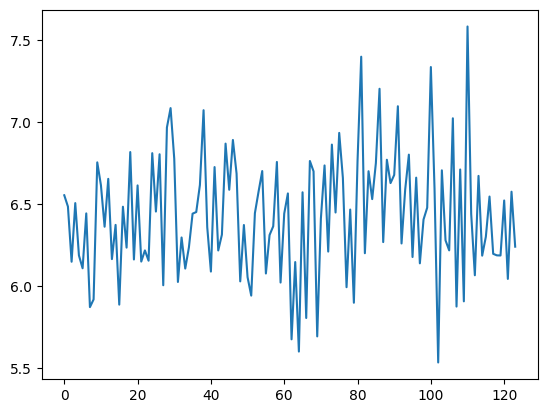

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load the fine-tuned model and tokenizer
model_name = "medLora-model"  # Replace with your model's path
model = AutoModelForCausalLM.from_pretrained(model_name)

# Evaluate the model
model.eval()
total_loss = 0
num_batches = 0
batch_size = 8  # Adjust based on your memory constraints
loss_hist = [] # Storing it, no use for now
with torch.no_grad():
    for i in range(0, len(val_dataset), batch_size):
        if(i+batch_size >= len(val_dataset)):
            break
        batch = val_dataset[i:i + batch_size]
        # Get input_ids and attention_mask from the batch
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask'] if 'attention_mask' in batch else None  # Optional

        # Pass input_ids as labels for loss calculation
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels= batch['labels'])
        
        loss = outputs.loss
        loss_hist.append(loss)
        total_loss += loss.item()
        num_batches += 1

# Calculate average loss and perplexity
average_loss = total_loss / num_batches
perplexity = torch.exp(torch.tensor(average_loss)).item()

print(f"Average Loss: {average_loss:.4f}")
print(f"Perplexity: {perplexity:.4f}")

In [ ]:
print(type(training_question))

<class 'dict'>


/home/richard/GPTLoRA/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Average Loss: 14.5246
Perplexity: 2032163.3750


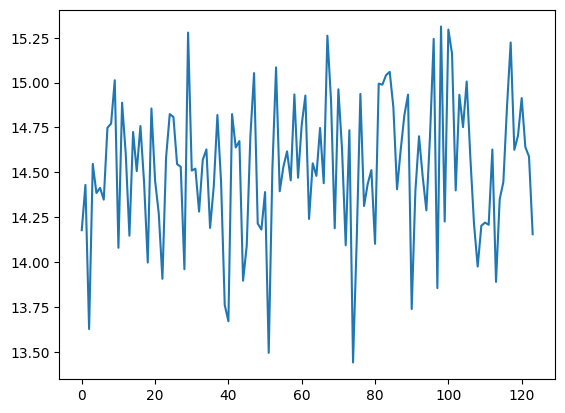

In [ ]:
# Load the default GPT-2 Small model and tokenizer
GPTmodel = "gpt2"  # This points to the default GPT-2 Small model
tokenizer = AutoTokenizer.from_pretrained(GPTmodel)
model = AutoModelForCausalLM.from_pretrained(GPTmodel)

# Evaluate the model
model.eval()
total_loss = 0
num_batches = 0
batch_size = 8  # Adjust based on your memory constraints

loss_hist = []
with torch.no_grad():
    for i in range(0, len(val_dataset), batch_size):
        if(i+batch_size >= len(val_dataset)):
            break
        batch = val_dataset[i:i + batch_size]
        # Get input_ids and attention_mask from the batch
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask'] if 'attention_mask' in batch else None  # Optional

        # Pass input_ids as labels for loss calculation
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels= batch['labels'])
        
        loss = outputs.loss
        loss_hist.append(loss)
        total_loss += loss.item()
        num_batches += 1

# Calculate average loss and perplexity
average_loss = total_loss / num_batches
perplexity = torch.exp(torch.tensor(average_loss)).item()

print(f"Average Loss: {average_loss:.4f}")
print(f"Perplexity: {perplexity:.4f}")